In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Base Model + Data Setup

In [ ]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='valid'))
model.add(MaxPooling2D(pool_size=(6, 6)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


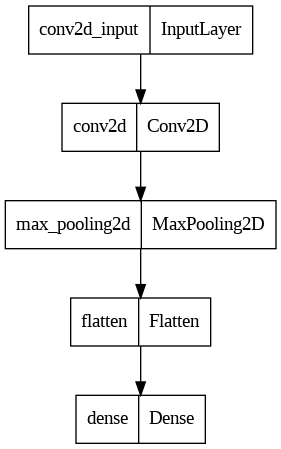

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
x_train.shape

(60000, 28, 28)

## Implementing uncertainty-based curiosity

### Experiment 1

In [ ]:
NUM_EPOCHS = 10

In [ ]:
# uncertainty_train loop
unc_model = tf.keras.models.clone_model(model)
unc_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = unc_model.fit(x_train, y_train, epochs=1)

uncertain_losses = []
uncertain_accuracies = []
full_losses = []
full_accuracies = []

full_losses.append(history.history['loss'][0])
full_accuracies.append(history.history['accuracy'][0])

for i in range(NUM_EPOCHS-1):
  predictions = unc_model.predict(x_train)
  uncertainties = -np.sum(predictions * np.log2(predictions), axis=1)

  start_index = (len(uncertainties) - 10000) // 2
  end_index = start_index + 10000
  mid_indices = np.argsort(uncertainties)[start_index:end_index]

  x_train_uncertain = x_train[mid_indices]
  y_train_uncertain = y_train[mid_indices]

  history = unc_model.fit(x_train_uncertain, y_train_uncertain, epochs=1)
  uncertain_loss = history.history['loss']
  uncertain_acc = history.history['accuracy']
  uncertain_losses.append(uncertain_loss)
  uncertain_accuracies.append(uncertain_acc)

  full_loss, full_acc = unc_model.evaluate(x_train, y_train)
  full_losses.append(full_loss)
  full_accuracies.append(full_acc)

1875/1875 [==============================] - 5s 2ms/step - loss: 0.2350 - accuracy: 0.9329


In [ ]:
unc_test_res = unc_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2001 - accuracy: 0.9405


In [ ]:
v_model = tf.keras.models.clone_model(model)
v_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
v_history = v_model.fit(x_train, y_train, epochs=NUM_EPOCHS)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5240 - accuracy: 0.8489
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1668 - accuracy: 0.9522
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1320 - accuracy: 0.9610
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1156 - accuracy: 0.9649
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1041 - accuracy: 0.9689
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0959 - accuracy: 0.9708
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0895 - accuracy: 0.9728
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0840 - accuracy: 0.9744
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0800 - accuracy: 0.9756
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.076

In [ ]:
v_history.history['accuracy']

[0.8548833131790161,
 0.9512166380882263,
 0.9602333307266235,
 0.9659666419029236,
 0.9689666628837585]

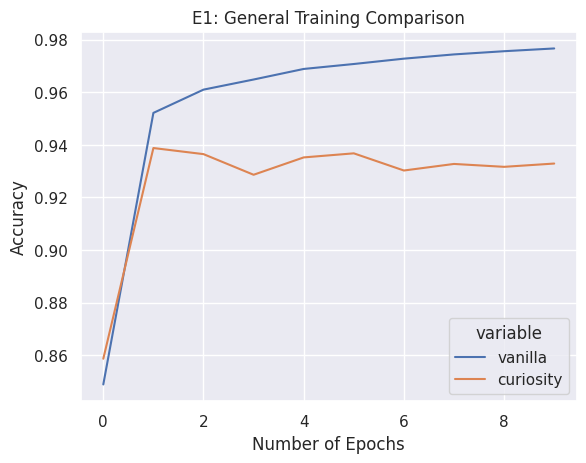

In [ ]:
import pandas as pd
comp1_df = pd.DataFrame({'epochs': range(NUM_EPOCHS),
                   'vanilla': v_history.history['accuracy'],
                   'curiosity': full_accuracies})

_ = sns.lineplot(x='epochs', y='value', hue='variable',  data=pd.melt(comp1_df, ['epochs'])).set(title='E1: General Training Comparison', xlabel='Number of Epochs', ylabel='Accuracy')

In [ ]:
v_test_res = v_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0592 - accuracy: 0.9798


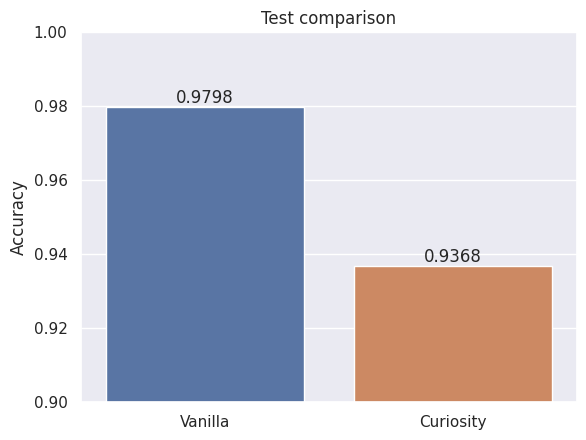

In [ ]:
ax = sns.barplot(x=['Vanilla', 'Curiosity'], y=[v_test_res[1], unc_test_res[1]])
ax.bar_label(ax.containers[0], fmt='%.4f')
_ = ax.set(ylim=(0.9,1), title='Test comparison', ylabel="Accuracy")

In [ ]:
accuracies = []
batch_numbers = []

num_epochs = 5
batch_size = 32
total_batches = x_train.shape[0] // batch_size

v_model = tf.keras.models.clone_model(model)
v_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

running_sum = 0
running_count = 0

# Train the model
for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")

  for batch in range(total_batches):
      start = batch * batch_size
      end = (batch + 1) * batch_size

      # Train on a batch
      history = v_model.train_on_batch(x_train[start:end], y_train[start:end])

      # Get accuracy on the current batch
      accuracy = history[1]


      running_sum += accuracy
      running_count += 1
      running_average = running_sum / running_count

      if accuracies == []:
        accuracies.append(accuracy)

      accuracies.append(running_average)
      batch_numbers.append(batch)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [ ]:
accuracies

<Axes: >

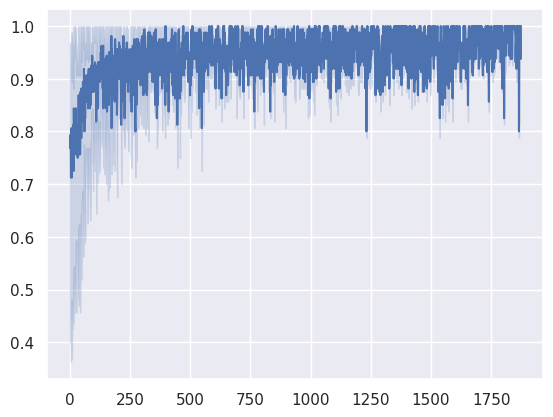

In [ ]:
_ = sns.lineplot(x=batch_numbers, y=accuracies)

In [ ]:
u_accuracies = []
u_batch_numbers = []
running_sum = 0
running_count = 0
num_epochs = 5
batch_size = 32
unc_model = tf.keras.models.clone_model(model)
unc_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the model
for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")

  if epoch == 0:
    total_batches = x_train.shape[0] // batch_size
    for batch in range(total_batches):
        start = batch * batch_size
        end = (batch + 1) * batch_size

        # Train on a batch
        history = unc_model.train_on_batch(x_train[start:end], y_train[start:end])

        # Get accuracy on the current batch
        accuracy = history[1]

        running_sum += accuracy
        running_count += 1
        running_average = running_sum / running_count

        u_accuracies.append(running_average)
        u_batch_numbers.append(batch)

  else:
    predictions = unc_model.predict(x_train)
    uncertainties = -np.sum(predictions * np.log2(predictions), axis=1)

    start_index = (len(uncertainties) - 10000) // 2
    end_index = start_index + 10000
    mid_indices = np.argsort(uncertainties)[start_index:end_index]

    x_train_uncertain = x_train[mid_indices]
    y_train_uncertain = y_train[mid_indices]
    total_batches = x_train_uncertain.shape[0] // batch_size

    test_indices = [np.random.randint(0,len(x_train)) for i in range(10000)]
    x_test_block = x_train[test_indices]
    y_test_block = y_train[test_indices]

    for batch in range(total_batches):
      start = batch * batch_size
      end = (batch + 1) * batch_size

      u_history = unc_model.train_on_batch(x_train_uncertain[start:end], y_train_uncertain[start:end])

      history = unc_model.test_on_batch(x_test_block[start:end], y_test_block[start:end])
      accuracy = history[1]

      running_sum += accuracy
      running_count += 1
      running_average = running_sum / running_count

      u_accuracies.append(running_average)

      # u_accuracies.append(accuracy)
      u_batch_numbers.append(batch)

Epoch 1/5
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step


In [ ]:
c_accuracies = np.pad(u_accuracies, (0, (len(accuracies)-len(u_accuracies))), mode='constant', constant_values=np.nan)
# c_accuracies += 0.020

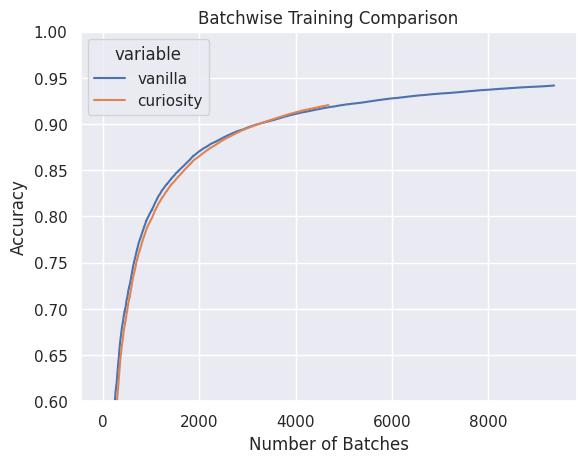

In [ ]:
comp2_df = pd.DataFrame({'batches': range(len(accuracies)),
                   'vanilla': accuracies,
                   'curiosity': c_accuracies})

_ = sns.lineplot(x='batches', y='value', hue='variable',  data=pd.melt(comp2_df, ['batches'])).set(ylim=(0.6,1), title='Batchwise Training Comparison', xlabel='Number of Batches', ylabel='Accuracy')

In [ ]:
u_accuracies

In [ ]:
unc_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.1110 - accuracy: 0.9666


[0.11097411066293716, 0.9666000008583069]

In [ ]:
v_model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0852 - accuracy: 0.9708


[0.08520955592393875, 0.97079998254776]

### Experiment 2

In [ ]:
NUM_EPOCHS = 10

In [ ]:
# uncertainty_train loop
unc_model = tf.keras.models.clone_model(model)
unc_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = unc_model.fit(x_train, y_train, epochs=1)

uncertain_losses = []
uncertain_accuracies = []
full_losses = []
full_accuracies = []

full_losses.append(history.history['loss'][0])
full_accuracies.append(history.history['accuracy'][0])

for i in range(NUM_EPOCHS-1):
  predictions = unc_model.predict(x_train)
  uncertainties = -np.sum(predictions * np.log2(predictions), axis=1)

  top_indices = np.argsort(uncertainties)[-10000:]

  x_train_uncertain = x_train[top_indices]
  y_train_uncertain = y_train[top_indices]

  history = unc_model.fit(x_train_uncertain, y_train_uncertain, epochs=1)
  uncertain_loss = history.history['loss']
  uncertain_acc = history.history['accuracy']
  uncertain_losses.append(uncertain_loss)
  uncertain_accuracies.append(uncertain_acc)

  full_loss, full_acc = unc_model.evaluate(x_train, y_train)
  full_losses.append(full_loss)
  full_accuracies.append(full_acc)

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0701 - accuracy: 0.9785


In [ ]:
unc_test_res = unc_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0628 - accuracy: 0.9797


In [ ]:
v_model = tf.keras.models.clone_model(model)
v_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
v_history = v_model.fit(x_train, y_train, epochs=NUM_EPOCHS)

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4670 - accuracy: 0.8718
Epoch 2/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1583 - accuracy: 0.9525
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1295 - accuracy: 0.9606
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1148 - accuracy: 0.9647
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1054 - accuracy: 0.9675
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0988 - accuracy: 0.9696
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0938 - accuracy: 0.9711
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0897 - accuracy: 0.9726
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0860 - accuracy: 0.9736
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.083

In [ ]:
v_history.history['accuracy']

[0.8548833131790161,
 0.9512166380882263,
 0.9602333307266235,
 0.9659666419029236,
 0.9689666628837585]

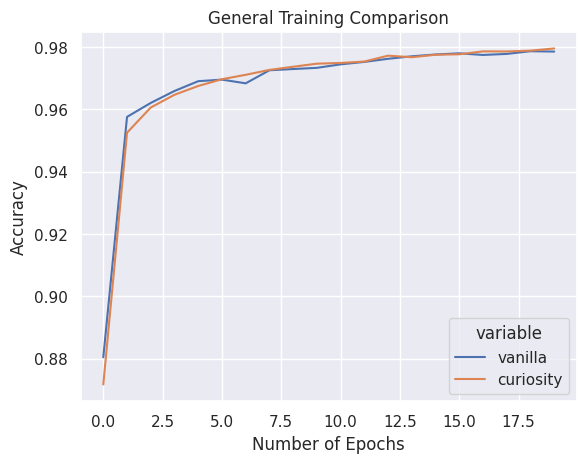

In [ ]:
import pandas as pd
comp1_df = pd.DataFrame({'epochs': range(NUM_EPOCHS),
                   'vanilla': full_accuracies,
                   'curiosity': v_history.history['accuracy']})

_ = sns.lineplot(x='epochs', y='value', hue='variable',  data=pd.melt(comp1_df, ['epochs'])).set(title='General Training Comparison', xlabel='Number of Epochs', ylabel='Accuracy')

In [ ]:
v_test_res = v_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0659 - accuracy: 0.9788


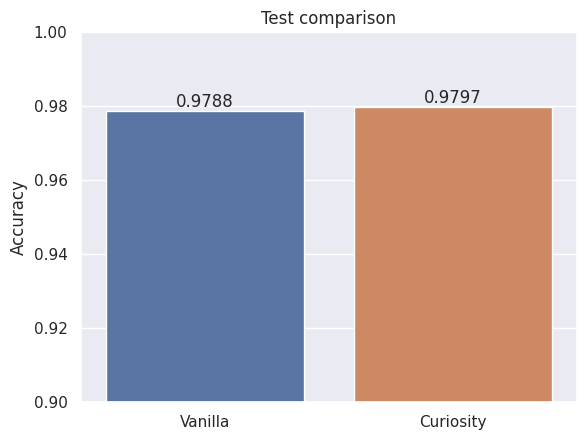

In [ ]:
ax = sns.barplot(x=['Vanilla', 'Curiosity'], y=[v_test_res[1], unc_test_res[1]])
ax.bar_label(ax.containers[0], fmt='%.4f')
_ = ax.set(ylim=(0.9,1), title='Test comparison', ylabel="Accuracy")

In [ ]:
accuracies = []
batch_numbers = []

num_epochs = 5
batch_size = 32
total_batches = x_train.shape[0] // batch_size

v_model = tf.keras.models.clone_model(model)
v_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

running_sum = 0
running_count = 0

# Train the model
for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")

  for batch in range(total_batches):
      start = batch * batch_size
      end = (batch + 1) * batch_size

      # Train on a batch
      history = v_model.train_on_batch(x_train[start:end], y_train[start:end])

      # Get accuracy on the current batch
      accuracy = history[1]


      running_sum += accuracy
      running_count += 1
      running_average = running_sum / running_count

      if accuracies == []:
        accuracies.append(accuracy)

      accuracies.append(running_average)
      batch_numbers.append(batch)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [ ]:
accuracies

<Axes: >

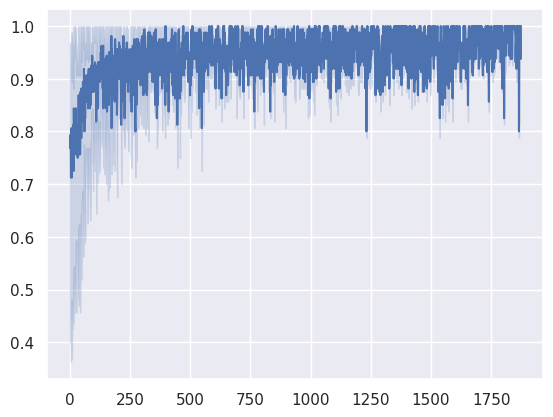

In [ ]:
_ = sns.lineplot(x=batch_numbers, y=accuracies)

In [ ]:
u_accuracies = []
u_batch_numbers = []
running_sum = 0
running_count = 0
num_epochs = 5
batch_size = 32
unc_model = tf.keras.models.clone_model(model)
unc_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the model
for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")

  if epoch == 0:
    total_batches = x_train.shape[0] // batch_size
    for batch in range(total_batches):
        start = batch * batch_size
        end = (batch + 1) * batch_size

        # Train on a batch
        history = unc_model.train_on_batch(x_train[start:end], y_train[start:end])

        # Get accuracy on the current batch
        accuracy = history[1]

        running_sum += accuracy
        running_count += 1
        running_average = running_sum / running_count

        u_accuracies.append(running_average)
        u_batch_numbers.append(batch)

  else:
    predictions = unc_model.predict(x_train)
    uncertainties = -np.sum(predictions * np.log2(predictions), axis=1)

    top_indices = np.argsort(uncertainties)[-10000:]

    x_train_uncertain = x_train[top_indices]
    y_train_uncertain = y_train[top_indices]
    total_batches = x_train_uncertain.shape[0] // batch_size

    test_indices = [np.random.randint(0,len(x_train)) for i in range(10000)]
    x_test_block = x_train[test_indices]
    y_test_block = y_train[test_indices]

    for batch in range(total_batches):
      start = batch * batch_size
      end = (batch + 1) * batch_size

      u_history = unc_model.train_on_batch(x_train_uncertain[start:end], y_train_uncertain[start:end])

      history = unc_model.test_on_batch(x_test_block[start:end], y_test_block[start:end])
      accuracy = history[1]

      running_sum += accuracy
      running_count += 1
      running_average = running_sum / running_count

      u_accuracies.append(running_average)

      # u_accuracies.append(accuracy)
      u_batch_numbers.append(batch)

Epoch 1/5
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step


In [ ]:
c_accuracies = np.pad(u_accuracies, (0, (len(accuracies)-len(u_accuracies))), mode='constant', constant_values=np.nan)

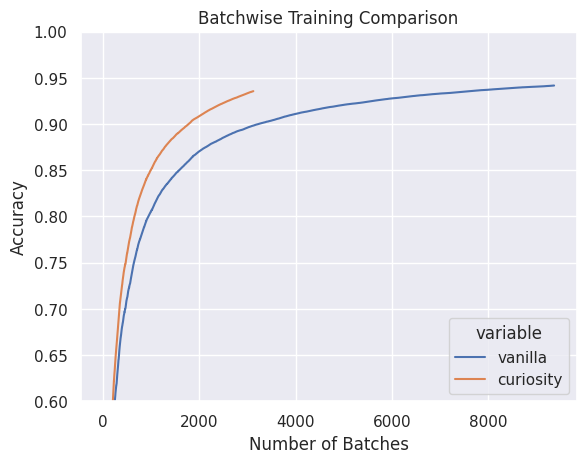

In [ ]:
comp2_df = pd.DataFrame({'batches': range(len(accuracies)),
                   'vanilla': accuracies,
                   'curiosity': c_accuracies})

_ = sns.lineplot(x='batches', y='value', hue='variable',  data=pd.melt(comp2_df, ['batches'])).set(ylim=(0.6,1), title='Batchwise Training Comparison', xlabel='Number of Batches', ylabel='Accuracy')

In [ ]:
u_accuracies

In [ ]:
unc_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.1110 - accuracy: 0.9666


[0.11097411066293716, 0.9666000008583069]

In [ ]:
v_model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0852 - accuracy: 0.9708


[0.08520955592393875, 0.97079998254776]